# Jacranda digital twin model


# Downsample

Using device: cuda
   Soil_ID   Depth_cm        pH  Organic_Matter_%  Moisture_Content_%  \
0        1   7.545292  6.774319          5.688127            5.244812   
1        2  12.457087  7.513037          2.386636           16.376238   
2        3  20.914292  5.312789          6.337647           27.751114   
3        4  15.891773  8.866207          8.569403           30.578007   
4        5  10.514443  4.620486          1.060762           29.815808   

   Bulk_Density_g/cm³  Nitrogen_N_ppm  Phosphorus_P_ppm  Potassium_K_ppm  \
0            1.059315      108.625130         46.862991       293.275470   
1            1.515582       51.700412         47.766455       187.908042   
2            1.501072       87.958725         28.553959       269.144602   
3            1.335978       37.371163         42.801129       288.942494   
4            0.924199       59.990423         37.288757       207.616835   

   Cation_Exchange_Capacity_meq/100g  Electrical_Conductivity_dS/m  \
0              

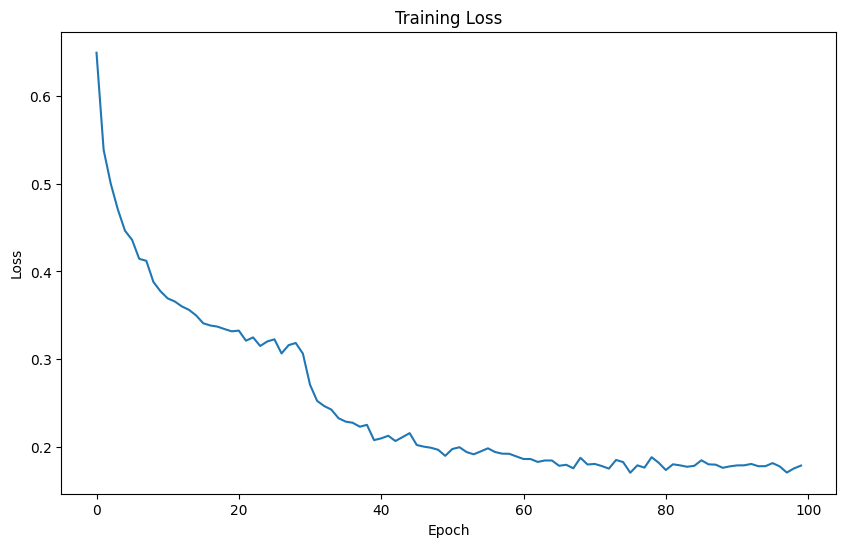

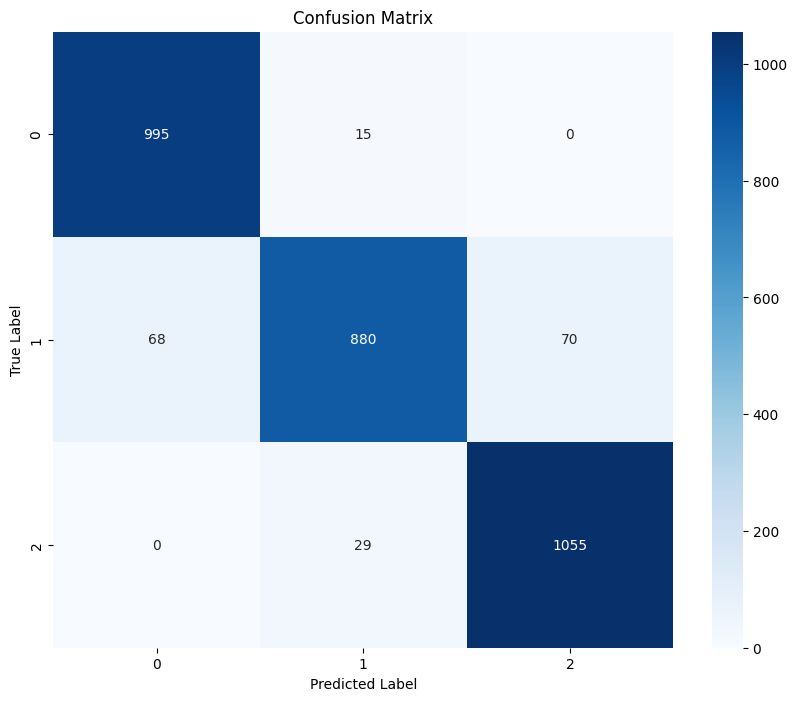

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1010
           1       0.95      0.86      0.91      1018
           2       0.94      0.97      0.96      1084

    accuracy                           0.94      3112
   macro avg       0.94      0.94      0.94      3112
weighted avg       0.94      0.94      0.94      3112



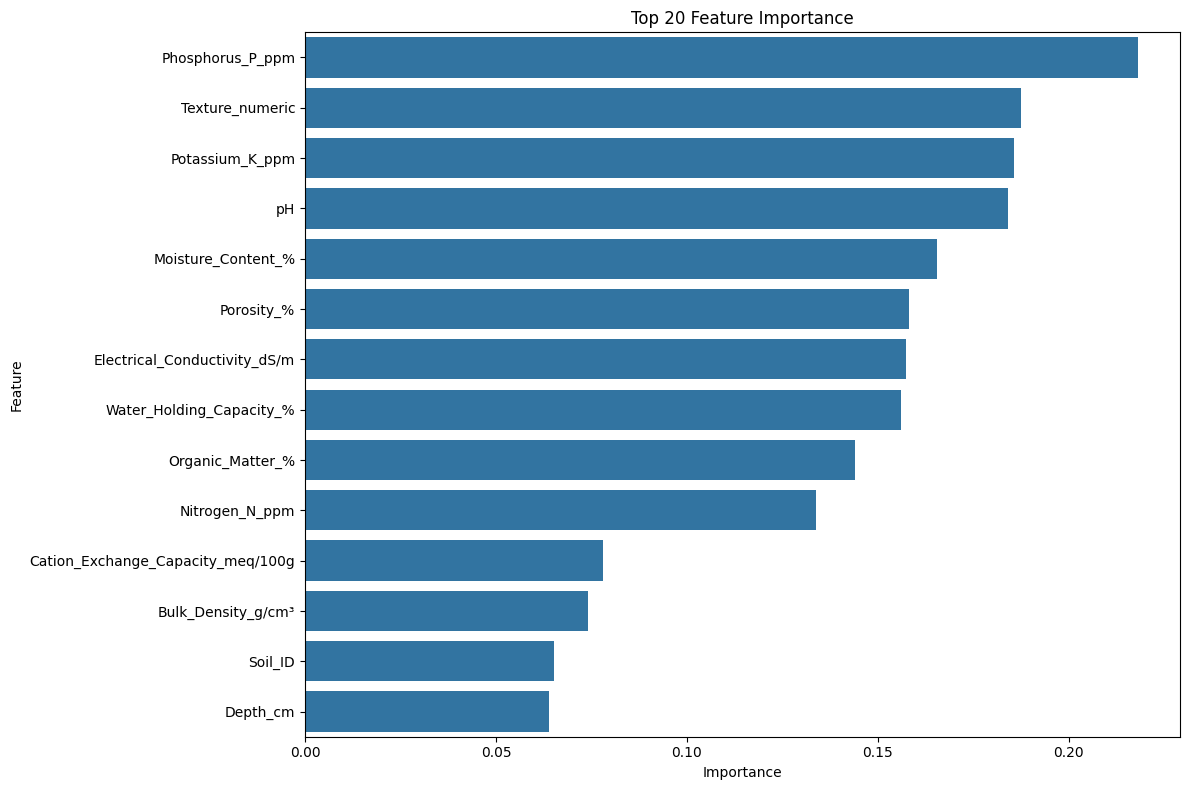

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class SoilClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SoilClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)

    # Drop unnecessary columns
    columns_to_drop = [col for col in df.columns if col.startswith('lon_') or col in ['year', 'month' , 'Location_Longitude', 'Location_Latitude']]
    df = df.drop(columns_to_drop, axis=1)
    print(df.head())
    # Upsample minority class
    df_upsampled = downsample_minority_class(df)

    # Prepare features and target
    X = df_upsampled.drop(['label'], axis=1)
    y = df_upsampled['label']

    print(y.value_counts())

    # Use LabelEncoder to ensure labels start from 0
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_train_tensor = torch.LongTensor(y_train)
    y_test_tensor = torch.LongTensor(y_test)

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, X_train.columns

def downsample_minority_class(df):
    data_majority_1 = df[df.label == 1]
    data_majority_2 = df[df.label == 2]
    data_minority = df[df.label == 0]

    data_majority_1_downsampled = resample(data_majority_1,
                                           replace=False,
                                           n_samples=int(data_minority.shape[0] * 2 ) ,
                                           random_state=123)
    data_majority_2_downsampled = resample(data_majority_2,
                                           replace=False,
                                           n_samples=int(data_minority.shape[0] * 2 ),
                                           random_state=123)

    data_minority = resample(data_minority,
                             replace=True,
                                n_samples=int(data_minority.shape[0] * 2),
                                random_state=123)


    return pd.concat([data_majority_1_downsampled, data_majority_2_downsampled, data_minority])


def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

def train_model(model, train_loader, criterion, optimizer, device, num_epochs=100):
    model.train()
    train_losses = []
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))
        scheduler.step()
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}')




    return train_losses

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    avg_loss = test_loss / len(test_loader)
    return accuracy, avg_loss, all_preds, all_labels

def plot_training_loss(train_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_feature_importance(model, feature_names):
    importance = torch.abs(model.fc1.weight).mean(dim=0).detach().cpu().numpy()
    feat_importance = pd.DataFrame({'feature': feature_names, 'importance': importance})
    feat_importance = feat_importance.sort_values('importance', ascending=False).head(20)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feat_importance)
    plt.title('Top 20 Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()


In [ ]:
# save the model pt
torch.save(model, 'soil_classifier.pt')